# Battle of Neighborhoods

### Capstone Project / IBM Data Science

_Dmitriy Yakovlev_ , 2020

---

## Introduction

This capstone project explores the best locations for pizzerias throughout the city of New York. With an estimated 2018 population of 8,398,748 distributed over about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States. And the city's population is constantly growing.
Therefore the need to find and enjoy perfect pizza is on the rise. This report explores which neighborhoods and boroughs of New York City have the most as well as the best pizzerias. Additionally, I will attempt to answer the questions:  
* "Where should I open a new pizzeria?"
* "Where should I stay if I want great pizza?"

These questions were put to me by my boss, who loves pizza, but is very demanding of it, so he wants to open a new nice pizzeria in New York. I promised to help him in these matters.

## Data

* In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, pizzeria, and pizzeri ratings and tips are required.  


* New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset  


* New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm  


* All data related to locations and quality of pizzerias will be obtained via the FourSquare API utilized via the Request library in Python.  

### Loading data

We will load and prepare the required data sets.

1. Initial NYC data

In [8]:
import pandas as pd
import requests

url  = 'https://cocl.us/new_york_dataset'
resp = requests.get(url).json()

# all data is present in features label
features = resp['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# instantiate the dataframe
nyc_data = pd.DataFrame(columns = column_names)
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    nyc_data = nyc_data.append({'Borough': borough,
                              'Neighborhood': neighborhood_name,
                              'Latitude': neighborhood_lat,
                              'Longitude': neighborhood_lon}, ignore_index = True)
    
nyc_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [9]:
nyc_data.shape

(306, 4)

2. We can see below that Manhattan has the least number of neighborhoods in all five buroughs.

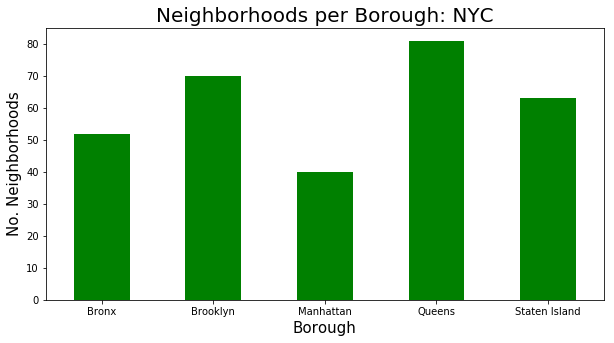

In [10]:
import matplotlib.pyplot as plt

nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize = (10, 5), color = "green")

plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods', fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

3. Analyzing further and see how many pizzerias there are in each neighborhood and burough and graph the results.

In [11]:
CLIENT_ID     = 'HVJYS425PQKTT3TPAYRBC5JZKOUDZQNLZJVRLBEEB4JLHQIU' # Foursquare ID
CLIENT_SECRET = 'ZPJPG4O453EMMWQCHYKENAJ1NUE30GTVTRCRZS35JIZIJKBU' # Foursquare Secret
VERSION       = '20190516' # Foursquare API version

In [12]:
import time

# Function for get venus
def get_venues(lat, lng):
    
    radius = 300
    LIMIT  = 50
    
    #url to fetch data from foursquare api
    while (True):
        time.sleep(1)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

        # get all the data
        results = requests.get(url).json()
        if (results['meta']['code'] == 200):
            break
        
    venue_data = results["response"]['groups'][0]['items']
    venues     = []
    for row in venue_data:
        try:
            venue_id       = row['venue']['id']
            venue_name     = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name']
            venues.append([venue_id,venue_name, venue_category])
        except KeyError:
            pass
    column_names = ['ID', 'Name','Category']
    df = pd.DataFrame(venues, columns = column_names)
    return df

In [13]:
# Prepare neighborhood list that contains pizzerias
column_names = ['Borough', 'Neighborhood', 'ID','Name']
df_pizzas    = pd.DataFrame(columns = column_names)
count        = 1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude, Longitude)

    pizzas = venues[venues['Category'] == 'Pizza Place']   
    print('(', count, '/', len(nyc_data), ')', 'Pizza Places in ' + Neighborhood + ', ' + Borough + ':' + str(len(pizzas)))
    print(row)
    for pizza_detail in pizzas.values.tolist():
        id, name, category = pizza_detail
        df_pizzas = df_pizzas.append({'Borough': Borough,
                                      'Neighborhood': Neighborhood, 
                                      'ID': id,
                                      'Name' : name
                                     }, ignore_index = True)
    count += 1

( 1 / 306 ) Pizza Places in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Pizza Places in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Pizza Places in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Pizza Places in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Pizza Places in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Pizza Places in Kingsbridge, Bronx:3
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Pizza Places in Marble Hill, Manhattan:1
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Pizza Places in Woodlawn, Bronx:2
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Pizza Places in Norwood, Bronx:1
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
( 10 /

In [14]:
df_pizzas.head()

Borough Neighborhood                        ID  \
0      Bronx   Co-op City  4d2cfa5cad25224bbbc5fb8f   
1      Bronx  Kingsbridge  502bd9a6e4b0bea49203e0aa   
2      Bronx  Kingsbridge  4b4fbdb5f964a520811327e3   
3      Bronx  Kingsbridge  4f21c904e4b0831873dc6256   
4  Manhattan  Marble Hill  4b4429abf964a52037f225e3   

                                    Name  
0                         Capri II Pizza  
1                   Little Caesars Pizza  
2                         Domino's Pizza  
3  Tony & Cyndi's Pizzeria & Restaurants  
4                               Arturo's

In [15]:
df_pizzas.to_csv('pizzas.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [16]:
df_pizzas = pd.read_csv('pizzas.csv')
df_pizzas.tail()

Unnamed: 0   Borough         Neighborhood                        ID  \
182         182     Bronx  Kingsbridge Heights  4c4f92763a6f2d7f79351076   
183         183     Bronx  Kingsbridge Heights  52f5553d11d2e2288f60a8f1   
184         184     Bronx  Kingsbridge Heights  4d9fc532e8a6721ec2c429a5   
185         185  Brooklyn              Erasmus  4d41f0bfaed776ebb2a56997   
186         186  Brooklyn              Erasmus  4cc4d4cb38aaa093f5801562   

                     Name  
182        emilio's Pizza  
183  Little Caesars Pizza  
184        Little Ceasars  
185        Domino's Pizza  
186        Little Ceasars

In [17]:
df_pizzas.shape

(187, 5)

As we continue our analysis, we see below that Brooklyn have the highest number if pizzerias. Additionally, we see how many pizzerias the top 6 neighborhoods have. The neighborhood of Belmont has the highest number of pizzerias in all of NYC and is actually located in the burough of Bronx vice Manhattan.

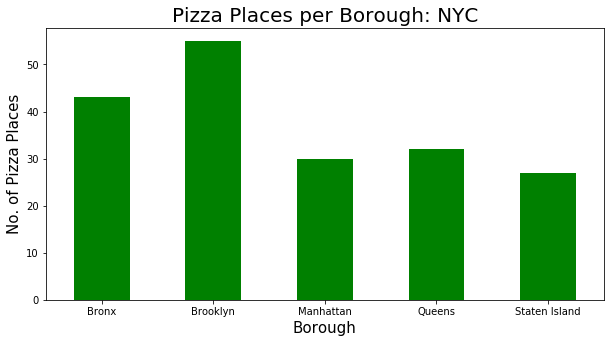

In [18]:
df_pizzas.groupby('Borough')['ID'].count().plot.bar(figsize = (10, 5), color = 'green')

plt.title('Pizza Places per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Pizza Places', fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

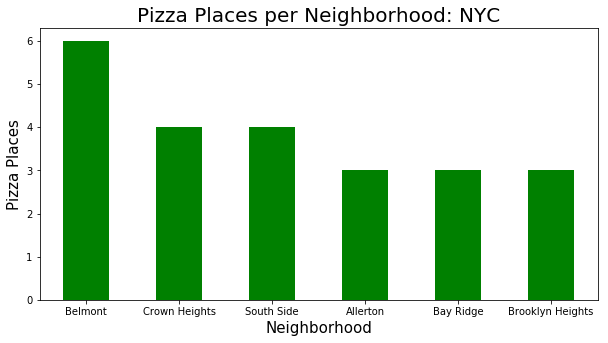

In [19]:
NOofNeigh = 6 # top number for graphing all the same past 6

df_pizzas.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize = (10, 5), color = 'green')

plt.title('Pizza Places per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Pizza Places', fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [20]:
df_pizzas.drop(['Unnamed: 0'], axis = 'columns', inplace = True)
df_pizzas[df_pizzas['Neighborhood'] == 'Belmont']

Borough Neighborhood                        ID  \
25   Bronx      Belmont  4aee1220f964a520ced121e3   
26   Bronx      Belmont  4aabd3e6f964a5204a5a20e3   
27   Bronx      Belmont  4b140a90f964a520489c23e3   
28   Bronx      Belmont  4b97fc62f964a5202a2435e3   
29   Bronx      Belmont  4b180daaf964a52024cc23e3   
30   Bronx      Belmont  4c2b699457a9c9b625d4f567   

                             Name  
25             Full Moon Pizzeria  
26                 Zero Otto Nove  
27                Bellini's Pizza  
28            Tony & Tina's Pizza  
29  University Pizza & Restaurant  
30               Ivana's Pizzeria

In [21]:
def get_venue_details(venue_id):
    
    while (True):
        time.sleep(1)
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

        # get all the data
        results = requests.get(url).json()
        if (results['meta']['code'] == 200):
            break
    
    venue_data    = results['response']['venue']
    venue_details = []
    try:
        venue_id     = venue_data['id']
        venue_name   = venue_data['name']
        venue_likes  = venue_data['likes']['count']
        venue_rating = venue_data['rating']
        venue_tips   = venue_data['tips']['count']
        venue_details.append([venue_id, venue_name, venue_likes, venue_rating, venue_tips])
    except KeyError:
        pass
    column_names = ['ID', 'Name', 'Likes', 'Rating', 'Tips']
    df = pd.DataFrame(venue_details, columns = column_names)
    return df

In [22]:
import pandas as pd
column_names = ['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']

df_pizza_stats = pd.DataFrame(columns = column_names)
count = 1
for row in df_pizzas.values.tolist():
    print(row)
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=', ID)
        # we will assign 0 value for these pizzas as they may have been 
        # recently opened or details does not exist in FourSquare Database
        id, name, likes, rating, tips = [0] * 5
    print('(', count, '/', len(df_pizzas), ')', 'processed')
    df_pizza_stats = df_pizza_stats.append({'Borough': Borough,
                                            'Neighborhood': Neighborhood, 
                                            'ID': id,
                                            'Name': name,
                                            'Likes': likes,
                                            'Rating': rating,
                                            'Tips': tips
                                           }, ignore_index = True)
    count += 1
df_pizza_stats.tail()

['Bronx', 'Co-op City', '4d2cfa5cad25224bbbc5fb8f', 'Capri II Pizza']
( 1 / 187 ) processed
['Bronx', 'Kingsbridge', '502bd9a6e4b0bea49203e0aa', 'Little Caesars Pizza']
( 2 / 187 ) processed
['Bronx', 'Kingsbridge', '4b4fbdb5f964a520811327e3', "Domino's Pizza"]
( 3 / 187 ) processed
['Bronx', 'Kingsbridge', '4f21c904e4b0831873dc6256', "Tony & Cyndi's Pizzeria & Restaurants"]
No data available for id= 4f21c904e4b0831873dc6256
( 4 / 187 ) processed
['Manhattan', 'Marble Hill', '4b4429abf964a52037f225e3', "Arturo's"]
( 5 / 187 ) processed
['Bronx', 'Woodlawn', '4ba50da6f964a52046d638e3', 'Katonah Pizza and Pasta']
( 6 / 187 ) processed
['Bronx', 'Woodlawn', '4bce1415ef10952199748386', "Linda's Pizza"]
No data available for id= 4bce1415ef10952199748386
( 7 / 187 ) processed
['Bronx', 'Norwood', '4bb626e0f562ef3b2fb32f97', "Sal's Pizzeria"]
( 8 / 187 ) processed
['Bronx', 'Baychester', '4ba2bf47f964a520db1538e3', 'Pizza Hut']
( 9 / 187 ) processed
['Bronx', 'Pelham Parkway', '4b48cef8f964a5

Borough         Neighborhood                        ID  \
182     Bronx  Kingsbridge Heights  4c4f92763a6f2d7f79351076   
183     Bronx  Kingsbridge Heights  52f5553d11d2e2288f60a8f1   
184     Bronx  Kingsbridge Heights  4d9fc532e8a6721ec2c429a5   
185  Brooklyn              Erasmus  4d41f0bfaed776ebb2a56997   
186  Brooklyn              Erasmus  4cc4d4cb38aaa093f5801562   

                     Name Likes  Rating Tips  
182        emilio's Pizza    11     6.7    2  
183  Little Caesars Pizza     0     6.3    1  
184        Little Ceasars     4     6.2    4  
185        Domino's Pizza     4     7.0    1  
186        Little Ceasars     4     5.9    3

In [23]:
df_pizza_stats.to_csv('pizza_stats.csv') # I continue to save data to a .csv as I move through this project

In [24]:
df_pizza_stats = pd.read_csv('pizza_stats.csv')
df_pizza_stats.shape

(187, 8)

In [25]:
df_pizza_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 8 columns):
Unnamed: 0      187 non-null int64
Borough         187 non-null object
Neighborhood    187 non-null object
ID              187 non-null object
Name            187 non-null object
Likes           187 non-null int64
Rating          187 non-null float64
Tips            187 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 11.8+ KB


In [26]:
df_pizza_stats['Likes'] = df_pizza_stats['Likes'].astype('float64')
df_pizza_stats['Tips']  = df_pizza_stats['Tips'].astype('float64')
df_pizza_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 8 columns):
Unnamed: 0      187 non-null int64
Borough         187 non-null object
Neighborhood    187 non-null object
ID              187 non-null object
Name            187 non-null object
Likes           187 non-null float64
Rating          187 non-null float64
Tips            187 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 11.8+ KB


In [27]:
df_pizza_stats.describe()

Unnamed: 0        Likes      Rating        Tips
count  187.000000   187.000000  187.000000  187.000000
mean    93.000000    61.320856    6.054545   20.262032
std     54.126395   193.166216    2.992323   58.020490
min      0.000000     0.000000    0.000000    0.000000
25%     46.500000     2.000000    6.100000    2.000000
50%     93.000000     9.000000    7.100000    5.000000
75%    139.500000    27.500000    8.000000   13.500000
max    186.000000  1262.000000    9.300000  596.000000

In [28]:
# Pizzerias with maximum Likes
df_pizza_stats.iloc[df_pizza_stats['Likes'].idxmax()]

Unnamed: 0                           103
Borough                        Manhattan
Neighborhood                Little Italy
ID              55ea9f4d498ed46db0383483
Name                      Champion Pizza
Likes                               1262
Rating                               9.1
Tips                                 149
Name: 103, dtype: object

In [29]:
# Pizzerias with maximum Ratings
df_pizza_stats.iloc[df_pizza_stats['Rating'].idxmax()]

Unnamed: 0                            79
Borough                         Brooklyn
Neighborhood                  South Side
ID              55135426498e9dee8f19cc5f
Name                L'Industrie Pizzeria
Likes                                124
Rating                               9.3
Tips                                  32
Name: 79, dtype: object

In [30]:
# Pizzerias with maximum Tips
df_pizza_stats.iloc[df_pizza_stats['Tips'].idxmax()]

Unnamed: 0                           174
Borough                         Brooklyn
Neighborhood                Fulton Ferry
ID              3fd66200f964a520e9e81ee3
Name                 Grimaldi's Pizzeria
Likes                               1132
Rating                               7.6
Tips                                 596
Name: 174, dtype: object

In [31]:
neighborhood_stats = df_pizza_stats.groupby('Neighborhood', as_index = False).mean()[['Neighborhood', 'Rating']]
neighborhood_stats.columns = ['Neighborhood', 'Average Rating']
neighborhood_stats.sort_values(['Average Rating'], ascending = False).head(10)

Neighborhood  Average Rating
35            Elmhurst             9.3
94                Soho             9.1
13       Carnegie Hill             9.1
76          North Side             8.9
34            Elm Park             8.9
50   Greenwich Village             8.8
18           Chinatown             8.8
39  Financial District             8.7
41         Fort Greene             8.6
96          South Side             8.6

In [32]:
borough_stats = df_pizza_stats.groupby('Borough', as_index = False).mean()[['Borough', 'Rating']]
borough_stats.columns = ['Borough', 'Average Rating']
borough_stats.sort_values(['Average Rating'], ascending = False).head()

Borough  Average Rating
2      Manhattan        7.803333
3         Queens        6.281250
1       Brooklyn        6.223636
0          Bronx        5.411628
4  Staten Island        4.522222

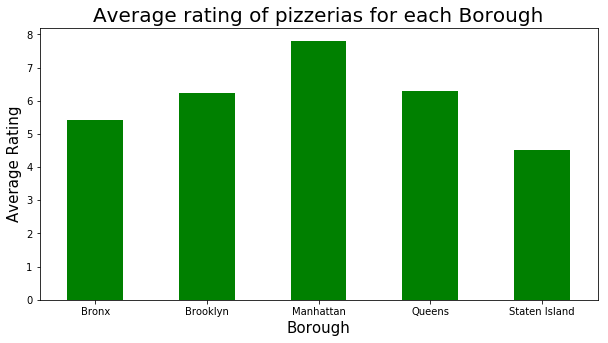

In [33]:
df_pizza_stats.groupby('Borough').mean()['Rating'].plot.bar(figsize = (10, 5), color = 'green')
plt.title('Average rating of pizzerias for each Borough', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [34]:
neighborhood_stats = neighborhood_stats[neighborhood_stats['Average Rating'] >= 9.0]
neighborhood_stats

Neighborhood  Average Rating
13  Carnegie Hill             9.1
35       Elmhurst             9.3
94           Soho             9.1

In [35]:
neighborhood_stats = pd.merge(neighborhood_stats, nyc_data, on = 'Neighborhood')
neighborhood_stats = neighborhood_stats[['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Average Rating']]
neighborhood_stats

Borough   Neighborhood   Latitude  Longitude  Average Rating
0  Manhattan  Carnegie Hill  40.782683 -73.953256             9.1
1     Queens       Elmhurst  40.744049 -73.881656             9.3
2  Manhattan           Soho  40.722184 -74.000657             9.1

In [42]:
# get geo location of address
def geo_location(address):
    geolocator = Nominatim(user_agent = "foursquare_agent")
    location   = geolocator.geocode(address)
    latitude   = location.latitude
    longitude  = location.longitude
    return latitude, longitude

In [45]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

# create map and display it
nyc_map = folium.Map(location = geo_location('New York'), zoom_start = 11)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius = 10,
            color = 'yellow',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.6
        )
    )

In [51]:
neighborhood_stats['Label'] = neighborhood_stats['Neighborhood'] + ', ' + neighborhood_stats['Borough'] + '(' + neighborhood_stats['Average Rating'].map(str) + ')'

# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_stats[['Latitude', 'Longitude', 'Label']].values:
    folium.Marker([lat, lng], popup = label).add_to(nyc_map)
    
!wget 'https://raw.githubusercontent.com/DmiProps/Coursera_Capstone/master/Borough%20Boundaries.geojson'
    
# add incidents to map
nyc_map.add_child(incidents)
nyc_geo = 'Borough Boundaries.geojson.2'
nyc_map.choropleth(
    geo_data = nyc_geo,
    data = borough_stats,
    columns = ['Borough', 'Average Rating'],
    key_on = 'feature.properties.boro_name',
    fill_color = 'YlOrRd', 
    fill_opacity = 0.7, 
    line_opacity = 0.2,
    legend_name = 'Average Rating'
)
nyc_map.save('borough_rating.html')
nyc_map

--2020-04-25 11:25:59--  https://raw.githubusercontent.com/DmiProps/Coursera_Capstone/master/Borough%20Boundaries.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2969945 (2.8M) [text/plain]
Saving to: ‘Borough Boundaries.geojson.2’

100%[======================================>] 2,969,945   --.-K/s   in 0.08s   

2020-04-25 11:25:59 (35.1 MB/s) - ‘Borough Boundaries.geojson.2’ saved [2969945/2969945]



Finally, we will visualize all NYC buroughs based on average Rating.

In [52]:
df_pizza_stats[df_pizza_stats['Likes'] >= 1000.0]

Unnamed: 0    Borough  Neighborhood                        ID  \
103         103  Manhattan  Little Italy  55ea9f4d498ed46db0383483   
105         105  Manhattan          Soho  55ea9f4d498ed46db0383483   
173         173   Brooklyn  Fulton Ferry  50ca6337e4b04e1f3135689c   
174         174   Brooklyn  Fulton Ferry  3fd66200f964a520e9e81ee3   

                    Name   Likes  Rating   Tips  
103       Champion Pizza  1262.0     9.1  149.0  
105       Champion Pizza  1262.0     9.1  149.0  
173      Juliana's Pizza  1010.0     8.9  314.0  
174  Grimaldi's Pizzeria  1132.0     7.6  596.0

## Results / Conclusion
Manhattan and Queens have the best rated pizzerias on average. Queens and The Bronx have the least amount of pizzerias per borough. However, of note, Belmont of The Bronx is the neighborhood in all of NYC with the most pizzerias. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most pizzerias.

Based on this information, I would state that Manhattan and Queens are the best locations for pizzeria in NYC. To have the best shot of success, I would open an pizzeria in Queens. Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of pizzerias making competition easier than in other boroughs. Finally, I would go to Champion Pizza in Manhattan for the best pizza based on 1262 likes.

As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.